# Why does a Telco customer churn?

## Project Planning

1. Project Summary & Goals
    
    Create a model that can predict customer churn better than a model that predicts only on the overal churn rate of 26%
    
    Perform Analysis that helps answer the folloring questions:
    * Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?
    
    * Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
    
    * Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
    
    * If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?
    
    
2. Pipeline Process:
     - Acquire - aquire data from the `customers` table from the `telco_churn` database on the codeup datascience database server.
      
     > *idea - join some tables as part of the query*. 
      
     > This data will be read into a pandas dataframe.
     
     > Summarize data (.info(), .describe(), .value_counts(), ...)
     
     > plot distributions of individual variables
     

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ignore_warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0003-MKNFE to 9975-GPKZU
Data columns (total 4 columns):
Electronic check             7032 non-null float64
Mailed check                 7032 non-null float64
Bank transfer (automatic)    7032 non-null float64
Credit card (automatic)      7032 non-null float64
dtypes: float64(4)
memory usage: 594.7+ KB


***Acquire the data from Sequel database telco_churn***

In [2]:
query = '''SELECT * 
           FROM customers
           JOIN contract_types USING (contract_type_id)
           JOIN internet_service_types USING (internet_service_type_id)
           JOIN payment_types using (payment_type_id)'''

db = 'telco_churn'

In [3]:
df = acquire.get_data_from_mysql(query,db)

***Describe the database***

In [4]:
# We will fill any empty spaces in the database with np.nan
df.replace([' ', '$', '<', '>',('NA').lower], np.nan, inplace = True)

In [5]:
# Check to find if there are any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [6]:
# We want to be able to handle total_charges as a numeric data type. 
df = df.astype({'total_charges': 'float64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [7]:
# Describe dataframe
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692,2283.300441
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047,2266.771362
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000,18.800000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000,401.450000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000,1397.475000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000,3794.737500
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000,8684.800000


In [8]:
# Calculate the population rate of churn to consider in variable distribtuions.

df.churn.value_counts(dropna = False)


No     5174
Yes    1869
Name: churn, dtype: int64

In [9]:
churn_yes = len(df.churn[df.churn == 'Yes'])
churn_no = len(df.churn[df.churn == 'No'])
churn_rate = churn_yes/(churn_yes + churn_no)
churn_yes, churn_no, churn_rate

(1869, 5174, 0.2653698707936959)

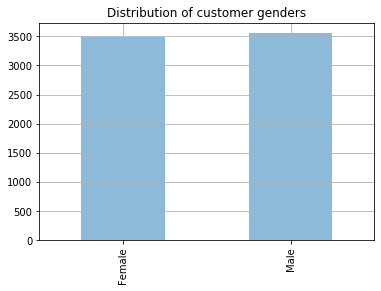

In [10]:
# Gender Variable Distribution
df.gender.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customer genders")
plt.grid(b= True, which = 'major')


In [11]:
df.gender.value_counts(dropna=False)

Male      3555
Female    3488
Name: gender, dtype: int64

In [12]:
p_male = (df.gender == 'Male').sum()/len(df.gender)
p_female = (df.gender == 'Female').sum()/len(df.gender)
p_male, p_female

(0.504756495811444, 0.495243504188556)

In [13]:
# View the proportions of male and female of customers who have churned.
# len(df[(df.churn == 'Yes') & (df.gender == 'Male')])/len(df.churn[df.churn == 'Yes'])

p_female_churn = len(df[(df.churn == 'Yes') & (df.gender == 'Female')])/3488
p_male_churn = len(df[(df.churn == 'Yes') & (df.gender == 'Male')])/3555
p_female_churn, p_male_churn

(0.26920871559633025, 0.2616033755274262)

Gender distribution: The distribution of gender looks almost even with male: 50%, female: 50%
The rate of churn for males and females is similar to that of the whole population

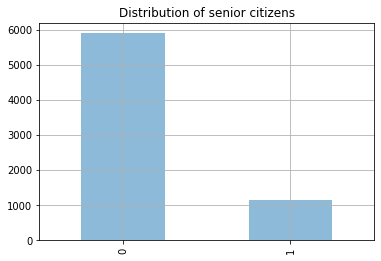

In [14]:
# Senior Citizen Variable
df.senior_citizen.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of senior citizens")
plt.grid(b= True, which = 'major')


In [15]:
#Curious to see what proportion of senior citizens churn 

In [16]:
df.churn.value_counts(dropna = False)

No     5174
Yes    1869
Name: churn, dtype: int64

In [17]:
 df.senior_citizen.value_counts(dropna=False)

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [18]:
len(df[(df.churn == 'Yes') & (df.senior_citizen == 1)])

476

In [19]:
476/1142, 476/1869

(0.4168126094570928, 0.2546816479400749)

***Take Away***: Senior citizens churn at twice the rate of the whole population. They also make up a quarter of customers who churned.

In [20]:
# Partner Distribution

In [21]:
df.partner.value_counts(dropna = False)

No     3641
Yes    3402
Name: partner, dtype: int64

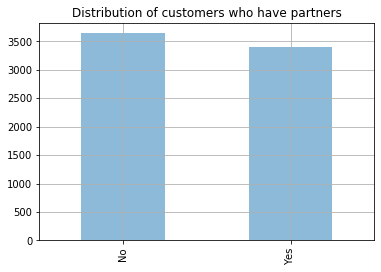

In [22]:
# bar plot
df.partner.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have partners")
plt.grid(b= True, which = 'major')


In [23]:
p_partner_churn = len(df[(df.churn == 'Yes') & (df.partner == 'Yes')])/len(df[df.partner == 'Yes'])
p_no_partner_churn = len(df[(df.churn == 'Yes') & (df.partner == 'No')])/len(df[df.partner == 'No'])
p_partner_churn, p_no_partner_churn



(0.1966490299823633, 0.32957978577313923)

***Take Aways:*** The distribution of customers who have partners and those who do not is almost even. The likelihood that some one churns who does not have a partner is higher than the population churn rate. Those who do have partner are lower than the population.

In [24]:
# Dependendents Variable Distribution

In [25]:
df.dependents.value_counts(dropna = False)

No     4933
Yes    2110
Name: dependents, dtype: int64

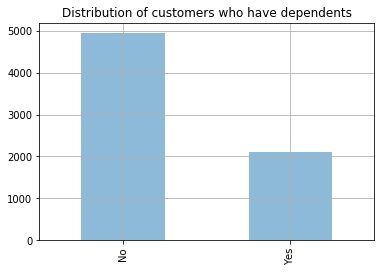

In [26]:
# bar plot
df.dependents.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have dependents")
plt.grid(b= True, which = 'major')


In [27]:
p_dependents_churn = len(df[(df.churn == 'Yes') & (df.dependents == 'Yes')])/len(df[df.dependents == 'Yes'])
p_no_dependents_churn = len(df[(df.churn == 'Yes') & (df.dependents == 'No')])/len(df[df.dependents == 'No'])
p_dependents_churn, p_no_dependents_churn


(0.15450236966824646, 0.3127914048246503)

***Take Aways:*** The amount of customers who have dependents is lower than those who do not. The likelihood that some one churns who does not have dependents is higher than the population churn rate. Those who do have dependents are lower than the population.

In [28]:
# Tenure Distribution

In [29]:
# Create a new column - Tenure years that will be their tenure amount (months) divided by 12.
df['tenure_years'] = df.tenure/12


In [30]:
df.tenure_years.value_counts(bins = 12, dropna = False).sort_index()

(-0.007, 0.5]    1481
(0.5, 1.0]        705
(1.0, 1.5]        548
(1.5, 2.0]        476
(2.0, 2.5]        431
(2.5, 3.0]        401
(3.0, 3.5]        379
(3.5, 4.0]        383
(4.0, 4.5]        420
(4.5, 5.0]        412
(5.0, 5.5]        463
(5.5, 6.0]        944
Name: tenure_years, dtype: int64

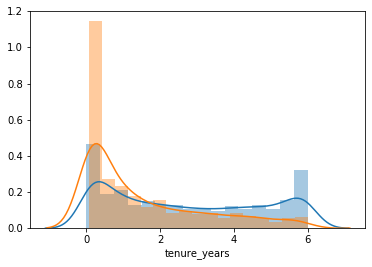

In [31]:
sns.distplot(df.tenure_years)
sns.distplot(df.tenure_years[df.churn == 'Yes'])

In [32]:
df.tenure_years[df.churn == 'Yes'].describe()

count    1869.000000
mean        1.498261
std         1.627594
min         0.083333
25%         0.166667
50%         0.833333
75%         2.416667
max         6.000000
Name: tenure_years, dtype: float64

In [33]:
df.tenure_years.describe()

count    7043.000000
mean        2.697596
std         2.046623
min         0.000000
25%         0.750000
50%         2.416667
75%         4.583333
max         6.000000
Name: tenure_years, dtype: float64

***Take Aways:*** The mean tenure for customers who churn is 1.5 with a standard deviation of 1.6. The mean of the population is 2.69 years with a standard deviation of 2.046. There is overlap around the centers of each these means and standard deviation. This would makes me think that that the average customer as a higher probability to churn.

In [34]:
# Phone Service Distribution

In [35]:
df.phone_service.value_counts(dropna = False)

Yes    6361
No      682
Name: phone_service, dtype: int64

In [36]:
# Majority of customers have phone service.

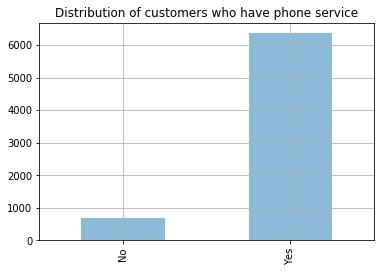

In [37]:
# bar plot
df.phone_service.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have phone service")
plt.grid(b= True, which = 'major')


In [38]:
p_phone_service_churn = len(df[(df.churn == 'Yes') & (df.phone_service == 'Yes')])/len(df[df.phone_service == 'Yes'])
p_no_phone_service_churn = len(df[(df.churn == 'Yes') & (df.phone_service == 'No')])/len(df[df.phone_service == 'No'])
p_phone_service_churn, p_no_phone_service_churn

(0.2670963684955196, 0.24926686217008798)

***Take Aways:*** whether a customer has phone service or not does not seem to have an affect on churn.

In [39]:
# Multiple-lines distribution

In [40]:
df.multiple_lines.value_counts(dropna = False)

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64

In [41]:
phone_service_customers = len(df.multiple_lines[df.phone_service == 'Yes'])
multiple_lines_yes = len(df.multiple_lines[df.multiple_lines == 'Yes'])
multiple_lines_no = len(df.multiple_lines[df.multiple_lines == 'No'])

prop_phone_service_multiple_lines = multiple_lines_yes/phone_service_customers

prop_phone_service_one_line = multiple_lines_no/phone_service_customers

prop_phone_service_multiple_lines, prop_phone_service_one_line


(0.46706492689828644, 0.5329350731017136)

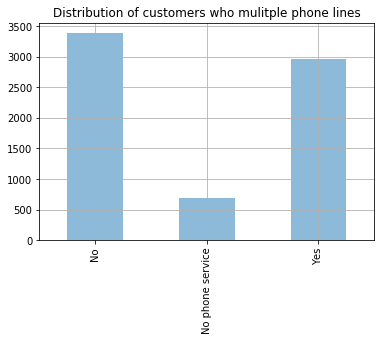

In [42]:
# bar plot
df.multiple_lines.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who mulitple phone lines")
plt.grid(b= True, which = 'major')


In [43]:
p_multiple_lines_churn = len(df[(df.churn == 'Yes') & (df.multiple_lines == 'Yes')])/len(df[df.multiple_lines == 'Yes'])
p_single_line_churn = len(df[(df.churn == 'Yes') & (df.multiple_lines == 'No')])/len(df[df.multiple_lines == 'No'])
p_multiple_lines_churn, p_single_line_churn


(0.286098956580276, 0.2504424778761062)

***Take Aways:*** The rate of churn for customers who have multiple lines, and those who don't have a churn rate that is similar to the overall population.

In [44]:
# Online-Security Variable Distribution:

In [45]:
df.online_security.value_counts(dropna = False)

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64

In [46]:
internet_service_customers = len(df.online_security) - len(df.online_security[df.online_security == 'No internet service'])
online_security_yes = len(df.online_security[df.online_security == 'Yes'])
online_security_no = len(df.online_security[df.online_security == 'No'])

prop_online_security_yes = online_security_yes/internet_service_customers

prop_online_security_no = online_security_no/internet_service_customers

prop_online_security_yes, prop_online_security_no


(0.36595976073953235, 0.6340402392604676)

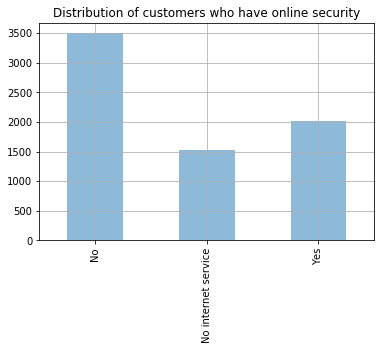

In [47]:
# bar plot
df.online_security.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have online security")
plt.grid(b= True, which = 'major')


In [48]:
p_online_security_churn = len(df[(df.churn == 'Yes') & (df.online_security == 'Yes')])/len(df[df.online_security == 'Yes'])
p_no_online_security_churn = len(df[(df.churn == 'Yes') & (df.online_security == 'No')])/len(df[df.online_security == 'No'])
p_online_security_churn, p_no_online_security_churn


(0.14611193660227836, 0.4176672384219554)

***Take Aways:*** The rate of churn for customers who do not have online security have a higher rate of churn than the whole population.

In [49]:
# Online backup variable distribution:

In [50]:
df.online_backup.value_counts(dropna = False)

No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64

In [51]:
internet_service_customers = len(df.online_backup) - len(df.online_backup[df.online_backup == 'No internet service'])
online_backup_yes = len(df.online_backup[df.online_backup == 'Yes'])
online_backup_no = len(df.online_backup[df.online_backup == 'No'])

prop_online_backup_yes = online_backup_yes/internet_service_customers

prop_online_backup_no = online_backup_no/internet_service_customers

prop_online_backup_yes, prop_online_backup_no


(0.44027551205365234, 0.5597244879463477)

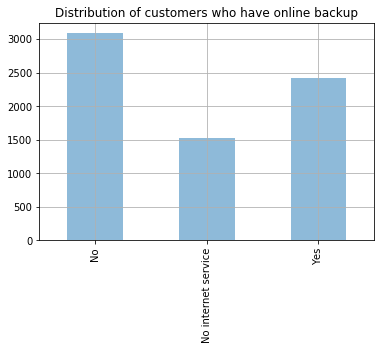

In [52]:
# bar plot
df.online_backup.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have online backup")
plt.grid(b= True, which = 'major')


In [53]:
p_online_backup_churn = len(df[(df.churn == 'Yes') & (df.online_backup == 'Yes')])/len(df[df.online_backup == 'Yes'])
p_no_online_backup_churn = len(df[(df.churn == 'Yes') & (df.online_backup == 'No')])/len(df[df.online_backup == 'No'])
p_online_backup_churn, p_no_online_backup_churn



(0.21531494442157267, 0.39928756476683935)

***Take Aways:*** The rate of churn for customers who have online backup is higher than the rate of churn for the population. The rate of churn for customers who do not have online backup is lower than the population.

In [54]:
# Device protection Distribution:
df.device_protection.value_counts(dropna=False)

No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64

In [55]:
internet_service_customers = len(df.device_protection) - len(df.device_protection[df.device_protection == 'No internet service'])
device_protection_yes = len(df.device_protection[df.device_protection == 'Yes'])
device_protection_no = len(df.device_protection[df.device_protection == 'No'])

prop_device_protection_yes = device_protection_yes/internet_service_customers

prop_device_protection_no = device_protection_no/internet_service_customers

prop_device_protection_yes, prop_device_protection_no


(0.4390067065434113, 0.5609932934565888)

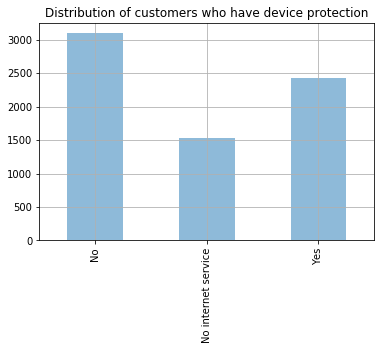

In [56]:
# bar plot
df.device_protection.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have device protection")
plt.grid(b= True, which = 'major')


In [57]:
p_device_protection_churn = len(df[(df.churn == 'Yes') & (df.device_protection == 'Yes')])/len(df[df.device_protection == 'Yes'])
p_no_device_protection_churn = len(df[(df.churn == 'Yes') & (df.device_protection == 'No')])/len(df[df.device_protection == 'No'])
p_device_protection_churn, p_no_device_protection_churn


(0.2250206440957886, 0.3912762520193861)

***Take Aways:*** The rate of churn for customers who do not have device protection is higher than the rate of churn for the population.

In [58]:
# Tech Support Variable Distribution:
df.tech_support.value_counts(dropna = False)

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64

In [59]:
internet_service_customers = len(df.tech_support) - len(df.tech_support[df.tech_support == 'No internet service'])
tech_support_yes = len(df.tech_support[df.tech_support == 'Yes'])
tech_support_no = len(df.tech_support[df.tech_support == 'No'])

prop_tech_support_yes = tech_support_yes/internet_service_customers

prop_tech_support_no = tech_support_no/internet_service_customers

prop_tech_support_yes, prop_tech_support_no


(0.37049120899039334, 0.6295087910096067)

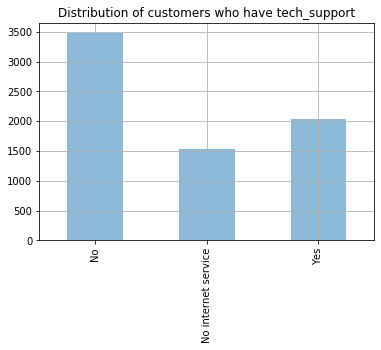

In [60]:
# bar plot
df.tech_support.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have tech_support")
plt.grid(b= True, which = 'major')


In [61]:
p_tech_support_churn = len(df[(df.churn == 'Yes') & (df.tech_support == 'Yes')])/len(df[df.tech_support == 'Yes'])
p_no_tech_support_churn = len(df[(df.churn == 'Yes') & (df.tech_support == 'No')])/len(df[df.tech_support == 'No'])
p_tech_support_churn, p_no_tech_support_churn


(0.15166340508806261, 0.4163547365390153)

***Take Aways:*** The rate of churn for customers who do not have tech support is higher than the population rate of churn.

In [62]:
# Streaming tv variable distribution:
df.streaming_tv.value_counts(dropna=False)

No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64

In [63]:
internet_service_customers = len(df.streaming_tv) - len(df.streaming_tv[df.streaming_tv == 'No internet service'])
streaming_tv_yes = len(df.streaming_tv[df.streaming_tv == 'Yes'])
streaming_tv_no = len(df.streaming_tv[df.streaming_tv == 'No'])

prop_streaming_tv_yes = streaming_tv_yes/internet_service_customers

prop_streaming_tv_no = streaming_tv_no/internet_service_customers

prop_streaming_tv_yes, prop_streaming_tv_no


(0.4906652166032264, 0.5093347833967736)

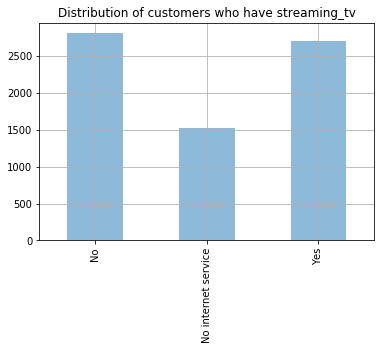

In [64]:
# bar plot
df.streaming_tv.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have streaming_tv")
plt.grid(b= True, which = 'major')


In [65]:
p_streaming_tv_churn = len(df[(df.churn == 'Yes') & (df.streaming_tv == 'Yes')])/len(df[df.streaming_tv == 'Yes'])
p_no_streaming_tv_churn = len(df[(df.churn == 'Yes') & (df.streaming_tv == 'No')])/len(df[df.streaming_tv == 'No'])
p_streaming_tv_churn, p_no_streaming_tv_churn


(0.30070188400443293, 0.33523131672597867)

***Take Aways:*** The rate of churn for customers who have streaming_tv and those who do not are similar. They are both close to the population rate of churn compared to other variables.

In [66]:
# Streaming_movies Variable Distribution:
df.streaming_movies.value_counts(dropna = False)

No                     2785
Yes                    2732
No internet service    1526
Name: streaming_movies, dtype: int64

In [67]:
internet_service_customers = len(df.streaming_movies) - len(df.streaming_tv[df.streaming_movies == 'No internet service'])
streaming_movies_yes = len(df.streaming_movies[df.streaming_movies == 'Yes'])
streaming_movies_no = len(df.streaming_movies[df.streaming_movies == 'No'])

prop_streaming_movies_yes = streaming_movies_yes/internet_service_customers

prop_streaming_movies_no = streaming_movies_no/internet_service_customers

prop_streaming_movies_yes, prop_streaming_movies_no


(0.49519666485408737, 0.5048033351459126)

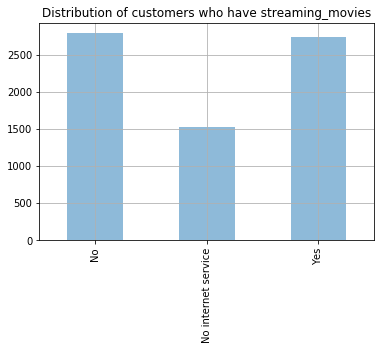

In [68]:
# bar plot
df.streaming_movies.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have streaming_movies")
plt.grid(b= True, which = 'major')


In [69]:
p_streaming_movies_churn = len(df[(df.churn == 'Yes') & (df.streaming_movies == 'Yes')])/len(df[df.streaming_movies == 'Yes'])
p_no_streaming_movies_churn = len(df[(df.churn == 'Yes') & (df.streaming_movies == 'No')])/len(df[df.streaming_movies == 'No'])
p_streaming_movies_churn, p_no_streaming_movies_churn


(0.29941434846266474, 0.33680430879712747)

***Take Aways:*** The rate of churn for streaming_movies does not differ much from the population churn rate as compared with other variables.

In [70]:
# Paperless Billing Distribution:
df.paperless_billing.value_counts(dropna=False)

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

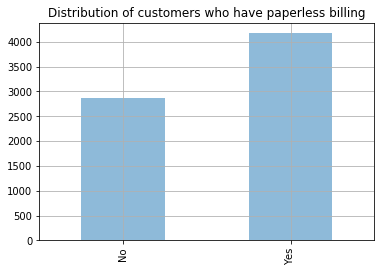

In [71]:
# bar plot
df.paperless_billing.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers who have paperless billing")
plt.grid(b= True, which = 'major')


In [72]:
p_paperless_billing_churn = len(df[(df.churn == 'Yes') & (df.paperless_billing == 'Yes')])/len(df[df.paperless_billing == 'Yes'])
p_no_paperless_billing_churn = len(df[(df.churn == 'Yes') & (df.paperless_billing == 'No')])/len(df[df.paperless_billing == 'No'])
p_paperless_billing_churn, p_no_paperless_billing_churn


(0.33565092304003835, 0.1633008356545961)

***Take Aways:*** The rate of churn for paperless_billing does not differ much from the population churn rate as compared with other variables.

In [73]:
# Monthly_charges Distribution:
df.monthly_charges.value_counts(bins = 10, dropna = False).sort_index()

(18.148999999999997, 28.3]    1606
(28.3, 38.35]                  191
(38.35, 48.4]                  365
(48.4, 58.45]                  640
(58.45, 68.5]                  474
(68.5, 78.55]                  893
(78.55, 88.6]                  953
(88.6, 98.65]                  873
(98.65, 108.7]                 754
(108.7, 118.75]                294
Name: monthly_charges, dtype: int64

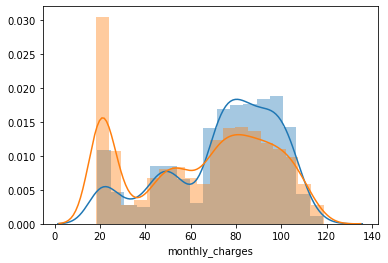

In [74]:
sns.distplot(df.monthly_charges[df.churn == 'Yes'])
sns.distplot(df.monthly_charges)

In [75]:
df.monthly_charges[df.churn == 'Yes'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64

In [76]:
df.monthly_charges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

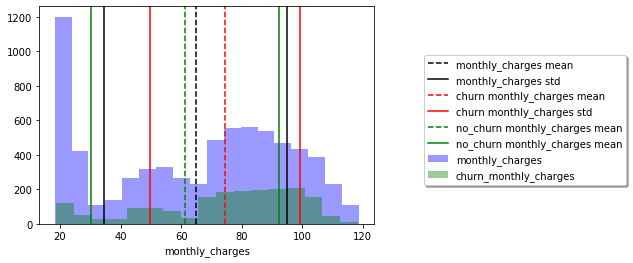

In [77]:
#fig2, ax2 = plt.subplots()
#sns.distplot(df.monthly_charges, color='b')
sns.distplot(df.monthly_charges, kde=False, norm_hist=False, color='b', label = 'monthly_charges')
sns.distplot(df.monthly_charges[df.churn == 'Yes'], kde = False, norm_hist = False, color ='g', label = 'churn_monthly_charges')
plt.axvline(x=df.monthly_charges.mean(), color = 'black', linestyle = '--', label = 'monthly_charges mean')
plt.axvline(x=df.monthly_charges.mean()+df.monthly_charges.std(), color = 'black', label = 'monthly_charges std')
plt.axvline(x=df.monthly_charges.mean()-df.monthly_charges.std(), color = 'black')
plt.axvline(x=df.monthly_charges[df.churn == 'Yes'].mean(), color = 'red', linestyle = '--',label = 'churn monthly_charges mean')
plt.axvline(x=df.monthly_charges[df.churn == 'Yes'].mean() + df.monthly_charges[df.churn == 'Yes'].std(), color = 'red', label = 'churn monthly_charges std')
plt.axvline(x=df.monthly_charges[df.churn == 'Yes'].mean() - df.monthly_charges[df.churn == 'Yes'].std(), color = 'red')
plt.axvline(x=df.monthly_charges[df.churn == 'No'].mean(), color = 'green',linestyle = '--', label = 'no_churn monthly_charges mean')
plt.axvline(x=df.monthly_charges[df.churn == 'No'].mean() + df.monthly_charges[df.churn == 'No'].std(), color = 'green', label = 'no_churn monthly_charges mean')
plt.axvline(x=df.monthly_charges[df.churn == 'No'].mean() - df.monthly_charges[df.churn == 'No'].std(), color = 'green')
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)


In [78]:
total = len(df.monthly_charges)
total

7043

In [79]:
monthly_charges_bins = np. array(df.monthly_charges.value_counts(dropna=False, bins = 10))
monthly_charges_bins

array([1606,  953,  893,  873,  754,  640,  474,  365,  294,  191])

***Take Aways:***  

The mean monthly_charges for customers who churn is 74.44 with a standard deviation of 24.66. This overlaps with the population mean of 64.76 and standard deviation of 30.00

In [80]:
# Total Charges Distribution:
df.total_charges.value_counts(dropna=False)



20.20      11
NaN        11
19.75       9
19.90       8
19.65       8
20.05       8
45.30       7
19.55       7
19.45       6
20.25       6
20.15       6
20.30       5
20.45       5
74.70       4
19.20       4
19.40       4
69.95       4
69.90       4
20.40       4
69.60       4
44.00       4
44.40       4
19.95       4
70.60       4
20.35       4
20.50       4
19.50       4
50.15       4
19.85       4
75.30       4
           ..
1834.15     1
999.80      1
8333.95     1
7171.70     1
3726.15     1
80.05       1
456.85      1
96.05       1
1399.35     1
2497.35     1
7069.30     1
688.65      1
6471.85     1
552.10      1
3242.50     1
3252.00     1
183.75      1
6886.25     1
7108.20     1
78.45       1
1171.30     1
3181.80     1
2540.10     1
3580.95     1
6470.10     1
3143.65     1
1110.50     1
1098.85     1
156.10      1
30.50       1
Name: total_charges, Length: 6531, dtype: int64

There are 11 missing values in out total_charges column. We we begin to prep we will look at how to handle this column.

In [81]:
# To get our distribution plot we will drop the NaN values
df_total_charges = df[['total_charges']].dropna()
df_total_charges.total_charges.value_counts(dropna=False).head()

20.20    11
19.75     9
20.05     8
19.90     8
19.65     8
Name: total_charges, dtype: int64

In [82]:
df_total_charges.describe()

,total_charges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


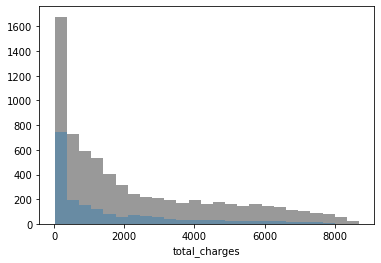

In [83]:
sns.distplot(df_total_charges, kde=False, norm_hist=False, color='black', label = 'monthly_charges')
sns.distplot(df.total_charges[df.churn == 'Yes'], kde = False, norm_hist = False)

In [84]:
# Contract Type Distribution:
df.contract_type.value_counts(dropna = False)

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

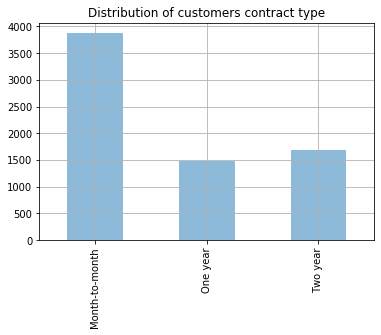

In [85]:
# bar plot
df.contract_type.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers contract type")
plt.grid(b= True, which = 'major')


In [86]:
p_month_to_month_churn = len(df[(df.churn == 'Yes') & (df.contract_type == 'Month-to-month')])/len(df[df.contract_type == 'Month-to-month'])
p_one_year_churn = len(df[(df.churn == 'Yes') & (df.contract_type == 'One year')])/len(df[df.contract_type == 'One year'])
p_two_year_churn = len(df[(df.churn == 'Yes') & (df.contract_type == 'Two year')])/len(df[df.contract_type == 'Two year'])
p_month_to_month_churn, p_one_year_churn, p_two_year_churn


(0.4270967741935484, 0.11269517990495587, 0.02831858407079646)

***Take-Aways** The customers with contacts Month-to-month have a higher rate of churn than the population churn rate. This is one of the higher churn rates, and will be one to consider.

In [87]:
# Internet Service Type Distribution:

In [88]:
df.internet_service_type.value_counts(dropna = False)

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

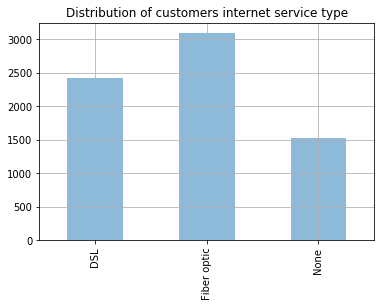

In [89]:
# bar plot
df.internet_service_type.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers internet service type")
plt.grid(b= True, which = 'major')


In [90]:
p_DSL_churn = len(df[(df.churn == 'Yes') & (df.internet_service_type == 'DSL')])/len(df[df.internet_service_type == 'DSL'])
p_Fiber_optic_churn = len(df[(df.churn == 'Yes') & (df.internet_service_type == 'Fiber optic')])/len(df[df.internet_service_type == 'Fiber optic'])
p_None_churn = len(df[(df.churn == 'Yes') & (df.internet_service_type == 'None')])/len(df[df.internet_service_type == 'None'])
p_DSL_churn, p_Fiber_optic_churn, p_None_churn


(0.1895910780669145, 0.4189276485788114, 0.07404980340760157)

***Take Aways:*** The rate of churn for customers who have fiber optic internet service is higher than the population rate of churn.

In [91]:
# Payment Type Distribution:
df.payment_type.value_counts(dropna = False)

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64

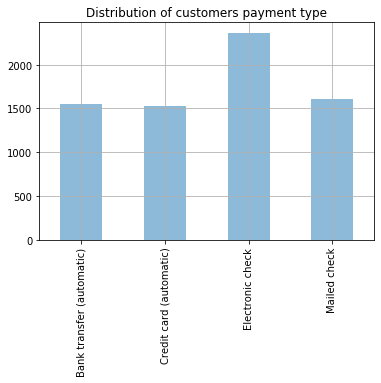

In [92]:
# bar plot
df.payment_type.value_counts(dropna = False).sort_index().plot(kind = "bar", alpha = .5)
plt.title("Distribution of customers payment type")
plt.grid(b= True, which = 'major')


In [93]:
p_bank_churn = len(df[(df.churn == 'Yes') & (df.payment_type == 'Bank transfer (automatic)')])/len(df[df.payment_type == 'Bank transfer (automatic)'])
p_credit_card_churn = len(df[(df.churn == 'Yes') & (df.payment_type == 'Credit card (automatic)')])/len(df[df.payment_type == 'Credit card (automatic)'])
p_elec_check_churn = len(df[(df.churn == 'Yes') & (df.payment_type == 'Electronic check')])/len(df[df.payment_type == 'Electronic check'])
p_mailed_check_churn = len(df[(df.churn == 'Yes') & (df.payment_type == 'Mailed check')])/len(df[df.payment_type == 'Mailed check'])
p_bank_churn, p_credit_card_churn, p_elec_check_churn, p_mailed_check_churn


(0.16709844559585493,
 0.15243101182654403,
 0.4528541226215645,
 0.19106699751861042)

***Take Aways:*** Customers who pay with electronic check have a higher rate of churn compared with the population rate of churn.

In [94]:
# In exploring these individual variables I want to create a model based on the following churn rates:
pd.DataFrame({'churn_rate': 
             {'p_Fiber_optic_churn': p_Fiber_optic_churn, 
              'p_month_to_month_churn': p_month_to_month_churn, 
              'p_elec_check_churn': p_elec_check_churn}})

,churn_rate
p_Fiber_optic_churn,0.418928
p_elec_check_churn,0.452854
p_month_to_month_churn,0.427097


#### Features that I will explore will be internet_service_type, payment_type, contract_type. Continues variables to consider will be monthly_charges, tenure, and total_charges


### Data Prep

Create new data frame in prepare.py file to explore the variables above

All of the data prep has been completed in the prepare.py file.

Below are my notes from my prepare.py file, and at the end I will return:

1. Aquire: create query, and use aquire.py to get telco data from SQL.


2. Set the index to customer_id. This will be helpful when predicting a specific customer's probability of churning.


3. Replace empty spaces ' ' with np.nan. This appears in out total_charges column.


4. After we replace ' ' (space) with np.nan we see that there are 7032 non-null values for total_charges. All other variables have 7043. 

    We see from the dataframe where total_charges.isna() has all tenure of 0. We can assume to mean that there is total_charges for these customers yet.
    
    Because these customers has no tenure, they have not had a opportunity to churn or not churn.
    
    Our data set is going to have enough over 7000 rows, so we will drop these rows. 
  
  
5. Create a new column named 'tenure_years' this converts our time of months into a measurement of years.


6. Create single variable representing the information from phone_service, and multiple lines


7. Do the same thing using dependents and partners.


8. total_charges is an object datatype. We need to change this to float using astype()


9. Create one_hot_encoder for payment, internet_service, and contract_type id's.


10. Next split the data into train, and test

In [95]:
# Return dataframes that were created from above in the prepare.py file

In [96]:
train = prepare.train
test = prepare.test
train_ohe = prepare.train_ohe
test_ohe = prepare.test_ohe

In [97]:
# Comment in and out lines to see the head of each dataframe

# train.head()
# test.head()
# train_ohe.head()
# test_ohe.head()

In [98]:
# Comment in a out lines to see the info of each dataframe

# train.info()
# test.info()
train_ohe.info()
# test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4922 entries, 8439-LTUGF to 2851-STERV
Data columns (total 36 columns):
payment_type_id              4922 non-null int64
internet_service_type_id     4922 non-null int64
contract_type_id             4922 non-null int64
gender                       4922 non-null object
senior_citizen               4922 non-null int64
partner                      4922 non-null object
dependents                   4922 non-null object
tenure                       4922 non-null int64
phone_service                4922 non-null object
multiple_lines               4922 non-null object
online_security              4922 non-null object
online_backup                4922 non-null object
device_protection            4922 non-null object
tech_support                 4922 non-null object
streaming_tv                 4922 non-null object
streaming_movies             4922 non-null object
paperless_billing            4922 non-null object
monthly_charges              4922 non-

# Data Exploration

In [99]:
len(train[train.churn == 'Yes'])/len(train.churn)

0.2657456318569687

1. Is there a month where the customer is more likely to churn? If a cohort is identified by tenure is there a cohort or cohorts who have a highter rate of churn than other cohorts? (Plot the rate of churn on a line where x is the tenure and y is the rate of churn (customers churned/total_customers

In [100]:
train[(train.tenure == 1) & (train.churn == 'Yes')]
train.churn.value_counts()

No     3614
Yes    1308
Name: churn, dtype: int64

In [101]:
x = range(1,73)
y = (([len(train[(train.tenure == i) & (train.churn == 'Yes')])/
       len(train[train.tenure == i])
      for i in range(1,max(train.tenure)+1)]))


In [102]:
# x
# y

Text(0.5, 1.0, 'Rate of Churn vs. Tenure')

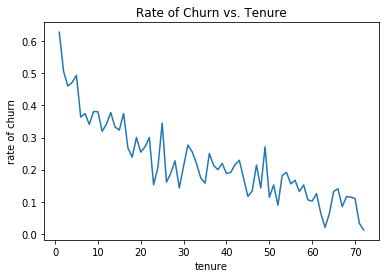

In [103]:
plt.plot(x,y)
plt.xlabel('tenure')
plt.ylabel('rate of churn')
plt.title('Rate of Churn vs. Tenure')

***Take Away:*** As tenure increases the rate of churn decreases. 

Are there features that indicate a higher propensity to churn? Like type of internet service, type of phone service, only security and backup, senior citizens, paying more than x% of customers with the same services.

In [104]:
# Print the type of internet_service, and churn rate
x = list(train.internet_service_type.unique())

for i in x:
    churn_customers = len(train[(train.internet_service_type == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.internet_service_type == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)



None 0.07677902621722846
Fiber optic 0.41770978210477516
DSL 0.1915144372421921


Those who have Fiber optic churn at a higher rate than the population. The rate of churn for customers who have Fiber Optic service is 41% the population churn rate is %26

In [105]:
x = list(train.phone_service.unique())

for i in x:
    churn_customers = len(train[(train.phone_service == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.phone_service == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

Yes 0.265635507733692
No 0.2668112798264642


Phone Service does not seem to have an effect on churn, the rate of churn for them is the same as the population.

In [106]:
x = list(train.multiple_lines.unique())

for i in x:
    churn_customers = len(train[(train.multiple_lines == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.multiple_lines == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

No 0.2512541806020067
Yes 0.28226196230062833
No phone service 0.2668112798264642


Multiple lines does not seem to have an effect on churn, the rate of churn for them is the same as the population.

In [107]:
x = list(train.online_security.unique())

for i in x:
    churn_customers = len(train[(train.online_security == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.online_security == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

No internet service 0.07677902621722846
Yes 0.1492109038737446
No 0.4138211382113821


Those who have No Online Security churn at a higher rate than the population. The rate of churn for customers who have do not have online security service is 41% the population churn rate is 26%

In [108]:
x = list(train.online_backup.unique())

for i in x:
    churn_customers = len(train[(train.online_backup == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.online_backup == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

No internet service 0.07677902621722846
No 0.396496081143384
Yes 0.2172106824925816


Those who have No Onlne backup churn at a higher rate than the population.

In [109]:
# What proportion of customers who have no online security also have no backup.
prop_no_online_backup = len(train[(train.online_backup == 'No') & (train.online_security == 'No')])/len(train[train.online_backup == 'No'])
prop_no_online_security = len(train[(train.online_backup == 'No') & (train.online_security == 'No')])/len(train[train.online_security == 'No'])

prop_no_online_backup, prop_no_online_security

(0.7090825265099124, 0.6252032520325204)

Most of customes who have no online backup also do not have online security. We can propbably pick between these features.

In [110]:
#Senior Citizens
x = list(train.senior_citizen.unique())

for i in x:
    churn_customers = len(train[(train.senior_citizen == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.senior_citizen == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

0 0.2378652499396281
1 0.41357234314980795


Those who are senior citizens churn at a higher rate than the population. The rate of churn for customers who are senior citizens is 41% the population churn rate is 26%

In [111]:
x = list(train.contract_type.unique())

for i in x:
    churn_customers = len(train[(train.contract_type == i) & (train.churn == 'Yes')])
    i_customers = len(train[train.contract_type == i])
    churn_rate = churn_customers/i_customers
    print(i, churn_rate)

Month-to-month 0.42472324723247235
Two year 0.028448275862068967
One year 0.11787072243346007


Those who have a month to month contract churn at a higher rate than the population. The rate of churn for customers who have month to month contracts is 41% the population churn rate is 26%

In [112]:
# Paying more than x% of customers with same services?

In [113]:
# Look at Fiber Optic

In [246]:
#Amount of customers who have churned, and have fiber optic
len(train.monthly_charges[(train.churn == 'Yes') & (train.internet_service_type == 'Fiber optic')])

901

In [ ]:
#Amount of customers who have churned

In [248]:
len(train.churn[train.churn == 'Yes'])

1308

In [249]:
# Proportion of customers who have fiber optic and have churned to all of customers who have churned.
901/1308

0.6888379204892966

In [114]:
# Fiber optic customers who churn monthly_charges
f_c = train.monthly_charges[(train.churn == 'Yes') & (train.internet_service_type == 'Fiber optic')]
f_c.value_counts(bins = 10).sort_index()

(68.199, 73.26]     103
(73.26, 78.27]      114
(78.27, 83.28]      113
(83.28, 88.29]      118
(88.29, 93.3]       101
(93.3, 98.31]       129
(98.31, 103.32]     115
(103.32, 108.33]     78
(108.33, 113.34]     23
(113.34, 118.35]      7
Name: monthly_charges, dtype: int64

In [115]:
f_c.describe()

count    901.000000
mean      88.160488
std       11.802219
min       68.250000
25%       78.850000
50%       88.350000
75%       98.250000
max      118.350000
Name: monthly_charges, dtype: float64

In [116]:
# Fiber optic customers who do not churn monthly_charges
f = train.monthly_charges[(train.churn == 'No') & (train.internet_service_type == 'Fiber optic')]
f.value_counts(bins = 10).sort_index()

(68.54899999999999, 73.6]     81
(73.6, 78.6]                  91
(78.6, 83.6]                 125
(83.6, 88.6]                 110
(88.6, 93.6]                 165
(93.6, 98.6]                 175
(98.6, 103.6]                155
(103.6, 108.6]               178
(108.6, 113.6]               112
(113.6, 118.6]                64
Name: monthly_charges, dtype: int64

In [117]:
f.describe()

count    1256.000000
mean       93.860430
std        12.703798
min        68.600000
25%        84.300000
50%        94.750000
75%       104.400000
max       118.600000
Name: monthly_charges, dtype: float64

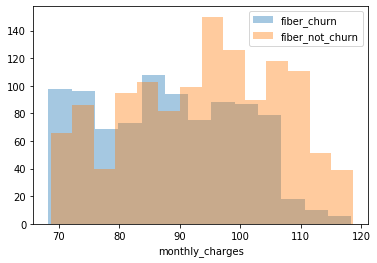

In [118]:
sns.distplot(f_c, kde = False, label = 'fiber_churn')
sns.distplot(f, kde = False, label = 'fiber_not_churn')
plt.legend()

***Take Aways:*** Those who pay more for Fiber Optic do not seem to churn



3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [119]:
train.monthly_charges[train.churn == 'Yes'].describe()

count    1308.000000
mean       74.176185
std        24.912099
min        18.850000
25%        56.100000
50%        79.650000
75%        94.250000
max       118.350000
Name: monthly_charges, dtype: float64

In [120]:
y = train.monthly_charges[train.churn =='Yes'].value_counts(bins = 10).sort_index()/len(train[train.churn=='Yes'])
y

(18.75, 28.8]      0.087920
(28.8, 38.75]      0.030581
(38.75, 48.7]      0.059633
(48.7, 58.65]      0.077217
(58.65, 68.6]      0.029817
(68.6, 78.55]      0.188838
(78.55, 88.5]      0.184251
(88.5, 98.45]      0.173547
(98.45, 108.4]     0.146024
(108.4, 118.35]    0.022171
Name: monthly_charges, dtype: float64

In [121]:
x = list(train.monthly_charges[train.churn =='Yes'].value_counts(bins = 10).sort_index().index)
# x = list([i*10 for i in range(1,13)])
# x

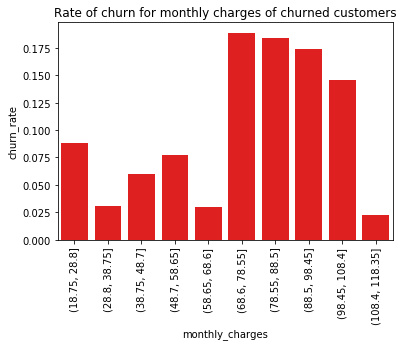

In [122]:
sns.barplot(x,y, color = 'red')
plt.ylabel('churn_rate')
plt.xlabel('monthly_charges')
plt.xticks(rotation = 90)
plt.title('Rate of churn for monthly charges of churned customers')
plt.show()

In [123]:
y1 = train.monthly_charges[(train.churn =='Yes') & (train.internet_service_type == 'Fiber optic')].value_counts(bins = 10).sort_index()/len(train[train.churn=='Yes'])
prop_churn_fiber = sum(y1)
prop_churn_fiber
y1

(68.199, 73.26]     0.078746
(73.26, 78.27]      0.087156
(78.27, 83.28]      0.086391
(83.28, 88.29]      0.090214
(88.29, 93.3]       0.077217
(93.3, 98.31]       0.098624
(98.31, 103.32]     0.087920
(103.32, 108.33]    0.059633
(108.33, 113.34]    0.017584
(113.34, 118.35]    0.005352
Name: monthly_charges, dtype: float64

In [124]:
x1 = list(train.monthly_charges[(train.churn =='Yes') & (train.internet_service_type == 'Fiber optic')].value_counts(bins = 10).sort_index().index)


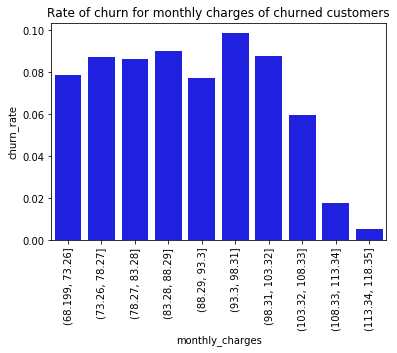

In [125]:
sns.barplot(x1,y1, color = 'blue' )
plt.ylabel('churn_rate')
plt.xlabel('monthly_charges')
plt.xticks(rotation = 90)
plt.title('Rate of churn for monthly charges of churned customers')
plt.show()

4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [126]:
#y = train.contract_type[train.churn =='Yes'].value_counts().sort_index()/len(train[train.churn=='Yes'])
train.contract_type[train.churn =='Yes'].value_counts().sort_index()/len(train[train.churn=='Yes'])


Month-to-month    0.879969
One year          0.094801
Two year          0.025229
Name: contract_type, dtype: float64

87% of our customers who churn have month to month contracts

In [127]:
fiber_contract_df = pd.DataFrame(train.contract_type[(train.churn =='Yes')\
                    & (train.internet_service_type == 'Fiber optic')]\
                    .value_counts().sort_index()/len(train[train.churn=='Yes'])).reset_index()
fiber_contract_df['proportions'] = fiber_contract_df['contract_type']
fiber_contract_df.drop(columns = 'contract_type',inplace = True)
fiber_contract_df['contract_type'] = fiber_contract_df['index']
fiber_contract_df.drop(columns = 'index', inplace = True)
fiber_contract_df

,proportions,contract_type
0,0.618502,Month-to-month
1,0.055046,One year
2,0.015291,Two year


In [128]:
train.contract_type[(train.churn =='Yes')\
                    & (train.internet_service_type == 'Fiber optic')]\
                    .value_counts().sort_index()/len(train[train.churn=='Yes'])

Month-to-month    0.618502
One year          0.055046
Two year          0.015291
Name: contract_type, dtype: float64

In [129]:
# Tenure for month-to-month contracts for customers who have Fiber optic,and churned.

In [130]:
a = train.tenure[(train.churn == 'Yes')\
             & (train.contract_type == 'Month-to-month')]\
            .value_counts(bins =12).sort_index()
a/sum(a)



(0.93, 6.75]     0.463076
(6.75, 12.5]     0.151173
(12.5, 18.25]    0.105126
(18.25, 24.0]    0.068636
(24.0, 29.75]    0.041703
(29.75, 35.5]    0.046047
(35.5, 41.25]    0.036490
(41.25, 47.0]    0.032146
(47.0, 52.75]    0.019983
(52.75, 58.5]    0.015639
(58.5, 64.25]    0.008688
(64.25, 70.0]    0.011295
Name: tenure, dtype: float64

In [131]:
sum(train.tenure[(train.churn == 'Yes')\
            & (train.contract_type == 'Month-to-month')\
            & (train.internet_service_type == 'Fiber optic')]\
            .value_counts(bins = 10).sort_index())

809

In [132]:
sum(train.tenure[(train.churn == 'Yes')\
            & (train.contract_type == 'Month-to-month')\
            & (train.internet_service_type == 'Fiber optic')
            & (train.tenure < 12)]\
            .value_counts().sort_index())

429

***Take Aways:*** Customers who have Fiber Optic month to month contracts over half who have churned have had tenure less than 12 months.

# Modeling



In [133]:
train_ohe.info()
# We need to change our target variable of 'churn' into a numberic value.

<class 'pandas.core.frame.DataFrame'>
Index: 4922 entries, 8439-LTUGF to 2851-STERV
Data columns (total 36 columns):
payment_type_id              4922 non-null int64
internet_service_type_id     4922 non-null int64
contract_type_id             4922 non-null int64
gender                       4922 non-null object
senior_citizen               4922 non-null int64
partner                      4922 non-null object
dependents                   4922 non-null object
tenure                       4922 non-null int64
phone_service                4922 non-null object
multiple_lines               4922 non-null object
online_security              4922 non-null object
online_backup                4922 non-null object
device_protection            4922 non-null object
tech_support                 4922 non-null object
streaming_tv                 4922 non-null object
streaming_movies             4922 non-null object
paperless_billing            4922 non-null object
monthly_charges              4922 non-

In [134]:
# To create churn as a numberic column of 0's and 1's create a list comprehension to run the values of the column through.
train_ohe.churn.value_counts()

No     3614
Yes    1308
Name: churn, dtype: int64

In [135]:
train_ohe['churn'] = [0 if i == 'No' else 1 for i in train_ohe.churn]

In [136]:
# Check the value counts
train_ohe.churn.value_counts()

0    3614
1    1308
Name: churn, dtype: int64

In [137]:
# Create the train datasets
X_train = train_ohe[['Electronic check',
                      'Mailed check',
                      'Bank transfer (automatic)',
                      'Credit card (automatic)',
                      'DSL',
                      'Fiber optic',
                      'None',
                      'Month-to-month',
                      'One year',
                      'Two year',
                      'monthly_charges',
                      'tenure',
                      'total_charges']]

X_train2 = train_ohe[['payment_type_id',
                      'contract_type_id',
                      'internet_service_type_id',
                      'senior_citizen',
                      'tenure',
                      'monthly_charges',
                      'total_charges',
                      'tenure_years']]

y_train = train_ohe[['churn']]

In [138]:
# Look at our X_train.head()
X_train.head()

,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year,monthly_charges,tenure,total_charges
customer_id,,,,,,,,,,,,,
8439-LTUGF,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,20.00,10,198.60
5339-PXDVH,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,90.65,4,367.95
9068-FHQHD,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,20.15,40,777.35
9475-NNDGC,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,113.15,71,7953.25
7268-IGMFD,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,93.90,18,1743.90


In [139]:
# Check our target variable values.
y_train.churn.value_counts()

0    3614
1    1308
Name: churn, dtype: int64

## Logistic Regression Model

In [140]:
# Create Logistic Regression model
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
logit2 = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')


In [142]:
# fit model to train data
logit.fit(X_train,y_train)
logit2.fit(X_train2,y_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
y_pred = logit.predict(X_train)
y_pred2 = logit2.predict(X_train2)

In [144]:
accuracy = logit.score(X_train,y_train)
accuracy2 = logit2.score(X_train2,y_train)
accuracy, accuracy2

(0.7003250711093052, 0.7031694433157253)

In [145]:
confusion_matrix(y_train, y_pred)

array([[2490, 1124],
       [ 351,  957]])

In [146]:
confusion_matrix(y_train,y_pred2)

array([[2503, 1111],
       [ 350,  958]])

In [147]:
print(classification_report(y_train,y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      3614
           1       0.46      0.73      0.57      1308

    accuracy                           0.70      4922
   macro avg       0.67      0.71      0.67      4922
weighted avg       0.77      0.70      0.72      4922



## Decision tree model

In [148]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 123)
clf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 123)

In [149]:
clf.fit(X_train, y_train)
clf2.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [150]:
y_pred_dt = clf.predict(X_train)
y_pred_dt2 = clf2.predict(X_train2)

In [151]:
clf.score(X_train,y_train)

0.8031288094270622

In [152]:
clf2.score(X_train2,y_train)

0.7982527427874848

In [153]:
confusion_matrix(y_train,y_pred_dt)

array([[3285,  329],
       [ 640,  668]])

In [154]:
confusion_matrix(y_train,y_pred_dt2)

array([[3253,  361],
       [ 632,  676]])

In [155]:
print(classification_report(y_train, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3614
           1       0.67      0.51      0.58      1308

    accuracy                           0.80      4922
   macro avg       0.75      0.71      0.73      4922
weighted avg       0.79      0.80      0.79      4922



## Random Forest

In [156]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

rf2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [157]:
rf.fit(X_train,y_train)
rf2.fit(X_train2,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [158]:
rf.feature_importances_
rf2.feature_importances_

array([0.08249056, 0.27710103, 0.10101679, 0.00614865, 0.18581114,
       0.11608228, 0.06651757, 0.16483197])

In [159]:
y_pred_rf = rf.predict(X_train)
y_pred_rf2 = rf2.predict(X_train2)

In [160]:
rf.score(X_train, y_train), rf2.score(X_train2,y_train)

(0.7846403900853312, 0.7901259650548558)

In [161]:
confusion_matrix(y_train, y_pred_rf)

array([[3419,  195],
       [ 865,  443]])

In [162]:
confusion_matrix(y_train,y_pred_rf2)

array([[3389,  225],
       [ 808,  500]])

In [163]:
print(classification_report(y_train,y_pred_rf2))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3614
           1       0.69      0.38      0.49      1308

    accuracy                           0.79      4922
   macro avg       0.75      0.66      0.68      4922
weighted avg       0.78      0.79      0.77      4922



## KNN

In [164]:
# Want to avoid too many dimensions will only select based on internet service fiber optic, contract type, tenure.
X_train_mod = train_ohe[['Fiber optic',
                      'Month-to-month',
                      'tenure',
                      'total_charges']]

In [165]:
# Create KNN object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn2 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_mod = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [166]:
knn.fit(X_train,y_train)
knn2.fit(X_train2,y_train)
knn_mod.fit(X_train_mod,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [167]:
y_pred_knn = knn.predict(X_train)
y_pred_knn2 = knn2.predict(X_train2)
y_pred_knn_mod = knn_mod.predict(X_train_mod)

In [168]:
knn.score(X_train,y_train), knn2.score(X_train2,y_train), knn_mod.score(X_train_mod,y_train)

(0.8264932954083706, 0.8264932954083706, 0.8226330759853718)

In [169]:
confusion_matrix(y_train, y_pred_knn)

array([[3347,  267],
       [ 587,  721]])

In [170]:
confusion_matrix(y_train, y_pred_knn2)

array([[3344,  270],
       [ 584,  724]])

In [171]:
print(classification_report(y_train,y_pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3614
           1       0.73      0.55      0.63      1308

    accuracy                           0.83      4922
   macro avg       0.79      0.74      0.76      4922
weighted avg       0.82      0.83      0.82      4922



***Insights:*** We want to look at factors where the rate of churn is more likely. We found those characteristics in internet_service_type, payment_type, contract_type the strongest. We also found higher rates of churn in the subgroups of senior_citizen, and online_security. To evaluate our results we will need to look at the confusion matrix, and classification reports of our models. From the confusion matrices we find that there are trade offs we get the most accuracy from K nearest neighbors, but we we are able to more accurately predict true churn in logistic regression.

***For improvement*** Keep exploring variables and where churn happens within those. Begin to refine variable selection into models, such as internet service type, and security.

### Simulation models

In [172]:
# If we predict no one to churn:
y_sim = [0 for i in range(0,len(train.churn))]

In [173]:
print(classification_report(y_train,y_sim))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      3614
           1       0.00      0.00      0.00      1308

    accuracy                           0.73      4922
   macro avg       0.37      0.50      0.42      4922
weighted avg       0.54      0.73      0.62      4922



In [200]:
# Selecting a random number between 0 and 1 for 4922 trials (same as test data)
a = np.random.random((4922,1))
a[0:5]

array([[0.82309427],
       [0.2154426 ],
       [0.57862387],
       [0.28774288],
       [0.75881104]])

In [210]:
# Establish the population churn_rate
churn_rate = len(train.churn[train.churn == 'Yes'])/len(train.churn)

In [211]:
# Where number is less than churn rate we will call that a "success" (the customer churned)

t = (a < churn_rate).sum(axis = 1)
t
churn_rate

0.2657456318569687

In [212]:
print(classification_report(y_train, t))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      3614
           1       0.27      0.26      0.26      1308

    accuracy                           0.61      4922
   macro avg       0.50      0.50      0.50      4922
weighted avg       0.61      0.61      0.61      4922



## Test Data

In [177]:
test_ohe['churn'] = [0 if i == 'No' else 1 for i in test_ohe.churn]
                     

In [178]:
test_ohe.churn.value_counts()

0    1549
1     561
Name: churn, dtype: int64

In [179]:
X_test = test_ohe[['Electronic check',
                      'Mailed check',
                      'Bank transfer (automatic)',
                      'Credit card (automatic)',
                      'DSL',
                      'Fiber optic',
                      'None',
                      'Month-to-month',
                      'One year',
                      'Two year',
                      'monthly_charges',
                      'tenure',
                      'total_charges']]

y_test = test_ohe[['churn']]

In [180]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')


In [181]:
logit.fit(X_test,y_test)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [182]:
y_pred_test = logit.predict(X_test)

In [183]:
logit.score(X_test,y_test)

0.6815165876777252

In [184]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1549
           1       0.44      0.75      0.56       561

    accuracy                           0.68      2110
   macro avg       0.66      0.70      0.65      2110
weighted avg       0.76      0.68      0.70      2110



***These recall scores are similar to our recall scores with the train data set***

In [185]:
# Create our probability predictions for the entire df.

st = prepare.ohe_df
st.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0003-MKNFE to 9975-GPKZU
Data columns (total 36 columns):
payment_type_id              7032 non-null int64
internet_service_type_id     7032 non-null int64
contract_type_id             7032 non-null int64
gender                       7032 non-null object
senior_citizen               7032 non-null int64
partner                      7032 non-null object
dependents                   7032 non-null object
tenure                       7032 non-null int64
phone_service                7032 non-null object
multiple_lines               7032 non-null object
online_security              7032 non-null object
online_backup                7032 non-null object
device_protection            7032 non-null object
tech_support                 7032 non-null object
streaming_tv                 7032 non-null object
streaming_movies             7032 non-null object
paperless_billing            7032 non-null object
monthly_charges              7032 non-

In [186]:
st.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [187]:
st['churn'] = [0 if i == 'No' else 1 for i in st.churn]

In [188]:
st.churn.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [189]:
y = st[['churn']]
X = st[['Electronic check',
        'Mailed check',
        'Bank transfer (automatic)',
        'Credit card (automatic)',
        'DSL',
        'Fiber optic',
        'None',
        'Month-to-month',
        'One year',
        'Two year',
        'monthly_charges',
        'tenure',
        'total_charges']]

In [190]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')


In [191]:
logit.fit(X,y)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
y_pred = pd.DataFrame(logit.predict(X), columns = ['y_pred'],index = st.index)
y_pred

,y_pred
customer_id,
0003-MKNFE,1
0013-MHZWF,1
0015-UOCOJ,1
0023-HGHWL,1
0032-PGELS,1
0067-DKWBL,1
0076-LVEPS,0
0082-LDZUE,1
0096-BXERS,1


In [193]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      5163
           1       0.47      0.73      0.57      1869

    accuracy                           0.71      7032
   macro avg       0.67      0.72      0.67      7032
weighted avg       0.77      0.71      0.72      7032



In [232]:
# Predict the probabilities of churn using logistic regression model:
y_pred_proba = pd.DataFrame(logit.predict_proba(X), columns = ['no_churn_proba','churn_proba'], index = st.index)
y_pred_proba
y_pred_proba.churn_proba[0]

0.6317197355379639

In [233]:
y

,churn
customer_id,
0003-MKNFE,0
0013-MHZWF,0
0015-UOCOJ,0
0023-HGHWL,1
0032-PGELS,1
0067-DKWBL,1
0076-LVEPS,0
0082-LDZUE,0
0096-BXERS,0


In [234]:
proba_df = y.join([y_pred,y_pred_proba])
proba_df

,churn,y_pred,no_churn_proba,churn_proba
customer_id,,,,
0003-MKNFE,0,1,0.368280,0.631720
0013-MHZWF,0,1,0.335687,0.664313
0015-UOCOJ,0,1,0.388534,0.611466
0023-HGHWL,1,1,0.414518,0.585482
0032-PGELS,1,1,0.395038,0.604962
0067-DKWBL,1,1,0.337901,0.662099
0076-LVEPS,0,0,0.615879,0.384121
0082-LDZUE,0,1,0.346262,0.653738
0096-BXERS,0,1,0.371761,0.628239


In [235]:
# export this file to a CSV
#export_csv = proba_df.to_csv (r'proba_churn.csv', header=True) #Don't forget to add '.csv' at the end of the path
#export_csv = df.to_csv (r'C:\Users\Ron\Desktop\export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

In [236]:
# Visualize model:

In [239]:
y_pred_proba_list = [y_pred_proba.churn_proba[i] for i in range(0,len(y_pred_proba.churn_proba))]
#y_pred_proba_list

Text(0.5, 1.0, 'What are the probability predictions for customers who churn?')

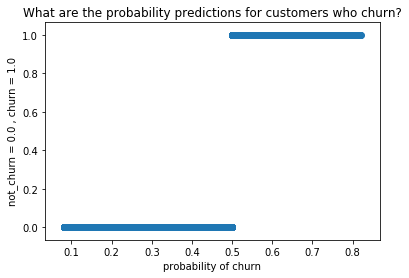

In [244]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba_list, y_pred)
plt.xlabel('probability of churn')
plt.ylabel('not_churn = 0.0 , churn = 1.0')
plt.title('What are the probability predictions for customers who churn?')